NEW NEW NEW
- new color definition
- reduced amount of times random method is executed
- class Autoencoder(Model): included input_shape and output_shape
- loooooops

In [1]:
import numpy as np
import pandas as pd
import random 
from random import randint
import time

import os
import json
from pathlib import Path

import tensorflow.keras as keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
#from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
#from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
data_path = Path('./kaggle_input/')
training_path = data_path / 'training'      # 400 X-train ('train'), y-train('test') input-output pairs
evaluation_path = data_path / 'evaluation'  # 400
test_path = data_path / 'test'              # 100 pairs X-train ('train') (input-output),
                                            #           y-train (input only) pairs

training_tasks_files = sorted(os.listdir(training_path))#[1:]
eval_tasks_files = sorted(os.listdir(evaluation_path))
test_task_files = sorted(os.listdir(test_path))

In [3]:
def load_files(path):
    path_files = sorted(os.listdir(path))
    tasks = []
    for task_file in path_files:
        with open(str(path / task_file), 'r') as f:
            task = json.load(f)
            tasks.append(task)
    return tasks

In [4]:
training_tasks = load_files(training_path)          ### this is for building / training the algorithm
test_tasks = load_files(test_path)                  ### this is the input for the actual prediction!!!
evaluation_tasks = load_files(evaluation_path)      ### testing the algorithm

In [5]:
len(training_tasks), training_tasks[0]['test']

(400,
 [{'input': [[7, 0, 7], [7, 0, 7], [7, 7, 0]],
   'output': [[7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 7, 0, 0, 0, 0, 7, 7, 0],
    [7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 7, 0, 0, 0, 0, 7, 7, 0],
    [7, 0, 7, 7, 0, 7, 0, 0, 0],
    [7, 0, 7, 7, 0, 7, 0, 0, 0],
    [7, 7, 0, 7, 7, 0, 0, 0, 0]]}])

In [6]:
len(evaluation_tasks), evaluation_tasks[0]['test']

(400,
 [{'input': [[3, 2], [7, 8]],
   'output': [[3, 2, 3, 2, 3, 2],
    [7, 8, 7, 8, 7, 8],
    [2, 3, 2, 3, 2, 3],
    [8, 7, 8, 7, 8, 7],
    [3, 2, 3, 2, 3, 2],
    [7, 8, 7, 8, 7, 8]]}])

In [7]:
len(test_tasks),test_tasks[0]['test']

(100, [{'input': [[3, 2], [7, 8]]}])

 
 ---
 ---

### 1. Create Train - Test - Split

In [8]:
def tts(input_list):
    Xs_test, ys_test, Xs_train, ys_train = [], [], [], []

    for task in input_list:
        X_test, y_test, X_train, y_train = [], [], [], []

        for pair in task["test"]:
            X_test.append(pair["input"])
            y_test.append(pair["output"])      ### to be predicted !!!

        for pair in task["train"]:
            X_train.append(pair["input"])
            y_train.append(pair["output"])

        Xs_test.append(X_test)
        ys_test.append(y_test)
        Xs_train.append(X_train)
        ys_train.append(y_train)
    return Xs_test, ys_test, Xs_train, ys_train

 
#### Create origanl sized Train-Test-Split for reference 

In [9]:
Xs_test_orig, ys_test_orig, Xs_train_orig, ys_train_orig = tts(training_tasks)

In [10]:
len(Xs_train_orig), len(ys_train_orig), len(Xs_test_orig), len(ys_test_orig)

(400, 400, 400, 400)

In [11]:
len(Xs_train_orig[1]), len(ys_train_orig[1]), len(Xs_test_orig[1]), len(ys_test_orig[1])

(5, 5, 1, 1)

 
#### Create actual Train-Test-Split


In [12]:
Xs_test, ys_test, Xs_train, ys_train = tts(training_tasks)

In [13]:
len(Xs_train), len(ys_train), len(Xs_test), len(ys_test)

(400, 400, 400, 400)

In [14]:
len(Xs_train[1]), len(ys_train[1]), len(Xs_test[1]), len(ys_test[1])

(5, 5, 1, 1)

## Data Augmentation of the training data

In [15]:
# #### color
# def color_change(arr):
#     x = arr*3
# #     x = x/(x.max()+0.1)
#     x = np.interp(x, (0.3, 2.7), (0, 0.9))
#     x = np.ndarray.round(x,1)
#     return x

In [16]:
def augm(X_list, y_list):
    idx = 1
    X_list_new = []
    y_list_new = []
    
    for task_X, task_y in zip(X_list, y_list):
        task_li_x = []
        task_li_y = []
        print("TASK",idx)
        length = len(Xs_train_orig[idx-1])
#         print(length)
        max_li=[]
        for i in range(length):
            max_a = max(len(task_X[i]),len(task_X[i][0]))
            max_b = max(len(task_y[i]),len(task_y[i][0]))
            max_ab = max(max_a,max_b)
            max_li.append(max_ab)
#             print(f"max_a = max({len(task_X[i])},{len(task_X[i][0])})")
#             print(f"max_b = max({len(task_y[i])},{len(task_y[i][0])})")
#             print(max_int)
        max_int = max(max_li)
            
        for e_x,e_y in zip(task_X, task_y):
            e_x = (np.array(e_x))/10.     
            e_y = (np.array(e_y))/10.
#             print(e_x.shape,e_y.shape, max_int)
            e_x = np.pad(e_x, [(0, max_int-e_x.shape[0]), (0, max_int-e_x.shape[1])], mode='constant')
            e_y = np.pad(e_y, [(0, max_int-e_y.shape[0]), (0, max_int-e_y.shape[1])], mode='constant')
#             print(e_x.shape,e_y.shape, max_int, "\n")
            task_li_x.append(e_x.reshape(e_x.shape + (1,) ))
            task_li_y.append(e_y.reshape(e_y.shape + (1,) ))
        # ========================
         
        while len(task_li_x) < 5000*length:    ###################
#             print(len(task_li_x))
            """
            choose a random method and append new array
            """
            i = randint(0,length-1) 
            new_x = (np.array(task_X[i]))/10.
#             print((new_x))
            new_y = (np.array(task_y[i]))/10.
            
            
            times = randint(1,5)
#             print(f"LENGTH: {len(task_X)} // INDEX: {i} // TIMES: {times}" )
            for j in range(times):
                
                method = random.choice([np.fliplr, np.flipud, np.rot90])#,color_change])
                new_x = method(new_x)
                new_y = method(new_y)

            new_x = np.pad(new_x, [(0, max_int-new_x.shape[0]), (0, max_int-new_x.shape[1])], mode='constant')

            new_y = np.pad(new_y, [(0, max_int-new_y.shape[0]), (0, max_int-new_y.shape[1])], mode='constant')

            
            task_li_x.append(new_x.reshape(new_x.shape + (1,) ))
            task_li_y.append(new_y.reshape(new_y.shape + (1,) ))
 
        X_list_new.append(np.array(task_li_x))
        y_list_new.append(np.array(task_li_y))

        idx +=1
    return     X_list_new, y_list_new

In [17]:
Xs_train_aug, ys_train_aug = augm(Xs_train, ys_train)

TASK 1
TASK 2
TASK 3
TASK 4
TASK 5
TASK 6
TASK 7
TASK 8
TASK 9
TASK 10
TASK 11
TASK 12
TASK 13
TASK 14
TASK 15
TASK 16
TASK 17
TASK 18
TASK 19
TASK 20
TASK 21
TASK 22
TASK 23
TASK 24
TASK 25
TASK 26
TASK 27
TASK 28
TASK 29
TASK 30
TASK 31
TASK 32
TASK 33
TASK 34
TASK 35
TASK 36
TASK 37
TASK 38
TASK 39
TASK 40
TASK 41
TASK 42
TASK 43
TASK 44
TASK 45
TASK 46
TASK 47
TASK 48
TASK 49
TASK 50
TASK 51
TASK 52
TASK 53
TASK 54
TASK 55
TASK 56
TASK 57
TASK 58
TASK 59
TASK 60
TASK 61
TASK 62
TASK 63
TASK 64
TASK 65
TASK 66
TASK 67
TASK 68
TASK 69
TASK 70
TASK 71
TASK 72
TASK 73
TASK 74
TASK 75
TASK 76
TASK 77
TASK 78
TASK 79
TASK 80
TASK 81
TASK 82
TASK 83
TASK 84
TASK 85
TASK 86
TASK 87
TASK 88
TASK 89
TASK 90
TASK 91
TASK 92
TASK 93
TASK 94
TASK 95
TASK 96
TASK 97
TASK 98
TASK 99
TASK 100
TASK 101
TASK 102
TASK 103
TASK 104
TASK 105
TASK 106
TASK 107
TASK 108
TASK 109
TASK 110
TASK 111
TASK 112
TASK 113
TASK 114
TASK 115
TASK 116
TASK 117
TASK 118
TASK 119
TASK 120
TASK 121
TASK 122
TASK 123
T

In [18]:
# def augm(X_list, y_list):
#     start = time.time()
# #     idx = 1
#     X_list_new = []
#     y_list_new = []
    
#     for task_X, task_y in zip(X_list, y_list):
# #         print(f"TASK {idx}")
#         task_x_li = []
#         task_y_li = []
        
#         for e_x, e_y in zip(task_X, task_y):
            
#             new_x = (np.array(e_x))/10.     
#             e_x_li = []
# #             e_x_li.append(new_x.reshape(new_x.shape + (1,) ))
            
#             new_y = (np.array(e_y))/10.
#             e_y_li = []
# #             e_y_li.append(new_y.reshape(new_y.shape + (1,) ))

#             max_int = max(max(new_x.shape),max(new_y.shape)) 
            
#             while len(e_x_li) < 500:                                      ###############
#                 """
#                 choose a random method and append new array
#                 """
#                 if len(e_x_li) > 0:
                    
#                     times = randint(1,4)
#                     for j in range(times):

#                         method = random.choice([np.fliplr, np.flipud, np.rot90])#,color_change])
#                         new_x = method(new_x)
#                         new_y = method(new_y)
                
#                 new_x = np.pad(new_x, [(0, max_int-new_x.shape[0]), (0, max_int-new_x.shape[1])], mode='constant')
# #                 new_x = new_x/10.
#                 new_y = np.pad(new_y, [(0, max_int-new_y.shape[0]), (0, max_int-new_y.shape[1])], mode='constant')
# #                 new_y = new_y/10.
                
#                 e_x_li.append(new_x.reshape(new_x.shape + (1,) ))
#                 e_y_li.append(new_y.reshape(new_y.shape + (1,) ))
                
#             task_x_li.append(np.array(e_x_li))
#             task_y_li.append(np.array(e_y_li))
            
#         X_list_new.append(task_x_li)
#         y_list_new.append(task_y_li)
            
# #         idx +=1
#     end = time.time()
 
#     print("Total time: " + str(np.round(end - start, 1)) + " s" + "\n")
#     return X_list_new, y_list_new

In [19]:
type(Xs_train_aug),len(Xs_train_aug)   ### number of Tasks

(list, 400)

In [20]:
type(Xs_train_aug[0]),len(Xs_train_aug[0]) ### number of sets

(numpy.ndarray, 25000)

In [21]:
type(Xs_train_aug[0][0]),Xs_train_aug[0][0].shape ### number of inputs (pairs)

(numpy.ndarray, (9, 9, 1))

#### format test data

In [22]:
def t2l(X_list, y_list):
    li_x =[]
    li_y =[]
    idx = 0
    for task_x, task_y in zip(X_list, y_list):
#         print("TASK", idx)
        task_x_arr = np.array(task_x)
        task_y_arr = np.array(task_y)
        li2_x = []
        li2_y = []
        for e_x, e_y in zip(task_x_arr, task_y_arr):
            e_x = np.array(e_x)
            e_y = np.array(e_y)
            
            max_int = max(max(e_x.shape),max(e_y.shape))
            
            
            e_x = np.pad(e_x, [(0, max_int-e_x.shape[0]), (0, max_int-e_x.shape[1])], mode='constant')
            e_x = e_x / 10.
            e_x = e_x.reshape(e_x.shape + (1,) )
#             print(e_x.shape, e_y.shape, max_int)
            e_y = np.pad(e_y, [(0, max_int-e_y.shape[0]), (0, max_int-e_y.shape[1])], mode='constant')
            e_y = e_y / 10.
            e_y = e_y.reshape(e_y.shape + (1,) )
#             print(e_x.shape, e_y.shape, "\n")
            li2_x.append(e_x)
            li2_y.append(e_y)

#         lenght = len(Xs_train_aug[idx])
        
#         li_x.append([np.array(li2_x)])
#         li_y.append([np.array(li2_y)])
        
        li_x.append(np.array(li2_x))
        li_y.append(np.array(li2_y))
        idx += 1
    return li_x, li_y

In [23]:
Xs_test_aug, ys_test_aug = t2l(Xs_test, ys_test)

/opt/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/opt/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/opt/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

In [24]:
type(Xs_train_aug), type(ys_train_aug),type(Xs_test_aug), type(ys_test_aug)

(list, list, list, list)

In [25]:
len(Xs_train_aug), len(ys_train_aug),len(Xs_test_aug), len(ys_test_aug)

(400, 400, 400, 400)

In [26]:
type(Xs_train_aug[0]), type(ys_train_aug[0]),type(Xs_test_aug[0]), type(ys_test_aug[0])

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [27]:
len(Xs_train_aug[0]), len(ys_train_aug[0]),len(Xs_test_aug[0]), len(ys_test_aug[0])

(25000, 25000, 1, 1)

In [28]:
Xs_train_aug[0].shape, ys_train_aug[0].shape,Xs_test_aug[0].shape, ys_test_aug[0].shape

((25000, 9, 9, 1), (25000, 9, 9, 1), (1, 9, 9, 1), (1, 9, 9, 1))

In [29]:
type(Xs_train_aug[0][0]), type(ys_train_aug[0][0]),type(Xs_test_aug[0][0]), type(ys_test_aug[0][0])

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [30]:
Xs_train_aug[2][2].shape, ys_train_aug[2][2].shape, Xs_test_aug[2][0].shape, ys_test_aug[2][0].shape

((9, 9, 1), (9, 9, 1), (9, 9, 1), (9, 9, 1))

## Model comp

In [31]:
class Autoencoder(Model):
    def __init__(self, latent_dim, inp_shape, outp_shape, flat_shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.inp_shape = inp_shape
        self.outp_shape = outp_shape
        self.flat_shape = flat_shape
        
        
        self.encoder = Sequential([
            layers.Conv2D(160, (3, 3), activation='relu', padding='same', input_shape = inp_shape), #### 
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = Sequential([
#             layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(flat_shape, activation='sigmoid'),
            layers.Reshape(outp_shape)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [32]:
for task in Xs_train_aug[:10]:
    print("=============")
    for each_set in task:
        print(each_set.shape)
#         print(type(each_set), len(each_set))

(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20, 20, 1)
(20,

(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21,

(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21,

(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21,

(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21,

(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21,

(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21,

(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21,

(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21,

(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21,

(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21,

(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(21, 21, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7,

(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)
(7, 7, 1)


(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14, 14, 1)
(14,

(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23,

(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23,

(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23,

(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23,

(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23,

(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23,

(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23,

(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23,

(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23,

(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23, 23, 1)
(23,

(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)
(9, 9, 1)


In [33]:
K.clear_session()  
latent_dim = 500 
idx = 0
#start = time.time()

for X_train, y_train, X_test, y_test in zip(Xs_train_aug[40:41], ys_train_aug[40:41], Xs_test_aug[40:41], ys_test_aug[40:41]):
    K.clear_session()  
    print(f"TASK {idx}")
    set_no = 0


    ### get input and output shapes to pass to the model
    inp_shape = X_train[0].shape
#         print('in', inp_shape)
    outp_shape = y_train[0].shape#[0]*y_set_train[0].shape[1]
#         print('out',outp_shape)
    flat_shape = outp_shape[0]*outp_shape[1]
#         print('flat',flat_shape)   
        
        
    K.clear_session() 
    base_model = Autoencoder(latent_dim, inp_shape, outp_shape, flat_shape)

    base_model.compile(optimizer='adam', 
                              loss='mean_squared_error',
                              metrics=['accuracy'])

    callback = keras.callbacks.EarlyStopping(monitor='accuracy',
                                                 patience=5)

    base_model.fit(X_train, y_train,
                          epochs=100,
                          batch_size=5000,
                          #shuffle=True,
    #                       verbose=0,
                          callbacks=[callback])#,
#                           validation_data=(X_set_test, y_set_test))        
        
        
    idx += 1


TASK 0
Epoch 1/100
3/3 [==============================] - 4s 786ms/step - loss: 0.1868 - accuracy: 0.5648
Epoch 2/100
3/3 [==============================] - 2s 786ms/step - loss: 0.1465 - accuracy: 0.7041
Epoch 3/100
3/3 [==============================] - 3s 827ms/step - loss: 0.0984 - accuracy: 0.7127
Epoch 4/100
3/3 [==============================] - 2s 752ms/step - loss: 0.0727 - accuracy: 0.7128
Epoch 5/100
3/3 [==============================] - 2s 693ms/step - loss: 0.0671 - accuracy: 0.7128
Epoch 6/100
3/3 [==============================] - 2s 659ms/step - loss: 0.0650 - accuracy: 0.7128
Epoch 7/100
3/3 [==============================] - 2s 680ms/step - loss: 0.0615 - accuracy: 0.7128
Epoch 8/100
3/3 [==============================] - 2s 688ms/step - loss: 0.0569 - accuracy: 0.7127
Epoch 9/100
3/3 [==============================] - 2s 818ms/step - loss: 0.0521 - accuracy: 0.7128


In [34]:
base_model.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 160)       1600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 160)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4000)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               2000500   
Total params: 2,002,100
Trainable params: 2,002,100
Non-trainable params: 0
_________________________________________________________________


In [35]:
base_model.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (5000, 100)               50100     
_________________________________________________________________
reshape (Reshape)            (5000, 10, 10, 1)         0         
Total params: 50,100
Trainable params: 50,100
Non-trainable params: 0
_________________________________________________________________


## MAKE PREDICTIONS

In [70]:
encoded_imgs = base_model.encoder(Xs_train_aug[40:41][0][:1]).numpy()
decoded_imgs = base_model.decoder(encoded_imgs).numpy()

pred_x = (decoded_imgs.reshape(10,10))*10

x = Xs_train_aug[40:41][0][:1]
     

x = (x.reshape(Xs_train_aug[40:41][0][0].shape[:2]))*10

y = (ys_train_aug[40:41][0][:1].reshape(ys_train_aug[40:41][0][0].shape[:2]))*10



test = Xs_test_aug[40:41][0][:1]

test = (test.reshape(Xs_test_aug[40:41][0][0].shape[:2]))*10

encoded_imgs2 = base_model.encoder(Xs_test_aug[40:41][0][:1]).numpy()
decoded_imgs2 = base_model.decoder(encoded_imgs2).numpy()

pred_t = (decoded_imgs2.reshape(10,10))*10

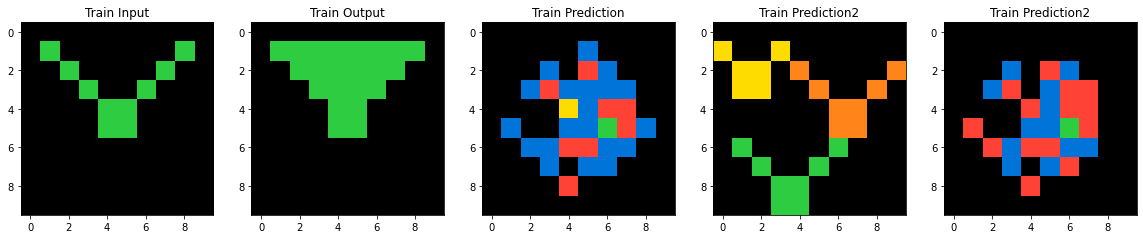

In [71]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(1, 5, figsize=(20,20))
ax[0].imshow(x, cmap=cmap, norm=norm)
ax[0].set_title('Train Input')
ax[1].imshow(y, cmap=cmap, norm=norm)
ax[1].set_title('Train Output')
ax[2].imshow(pred_x, cmap=cmap, norm=norm)
ax[2].set_title('Train Prediction')
ax[3].imshow(test, cmap=cmap, norm=norm)
ax[3].set_title('Train Prediction2')
ax[4].imshow(pred_t, cmap=cmap, norm=norm)
ax[4].set_title('Train Prediction2');

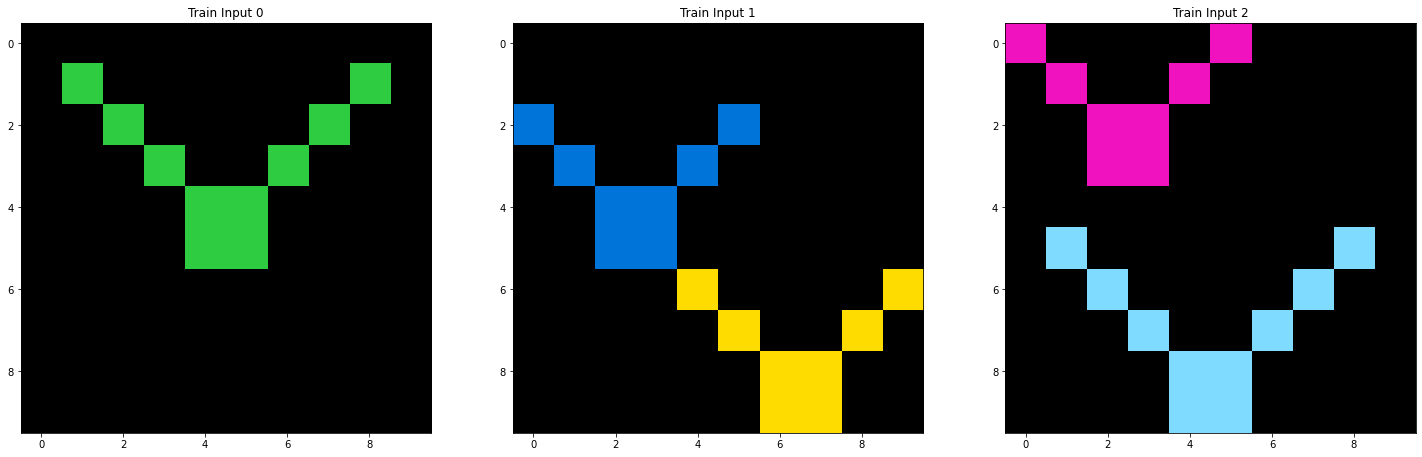

In [64]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(1, 3, figsize=(25,25))
for i in range(1):
    for j in range(3):
        idx = j
        
        ax[j].imshow((Xs_train_aug[40][idx])*10, cmap=cmap, norm=norm)
        ax[j].set_title(f'Train Input {idx}')

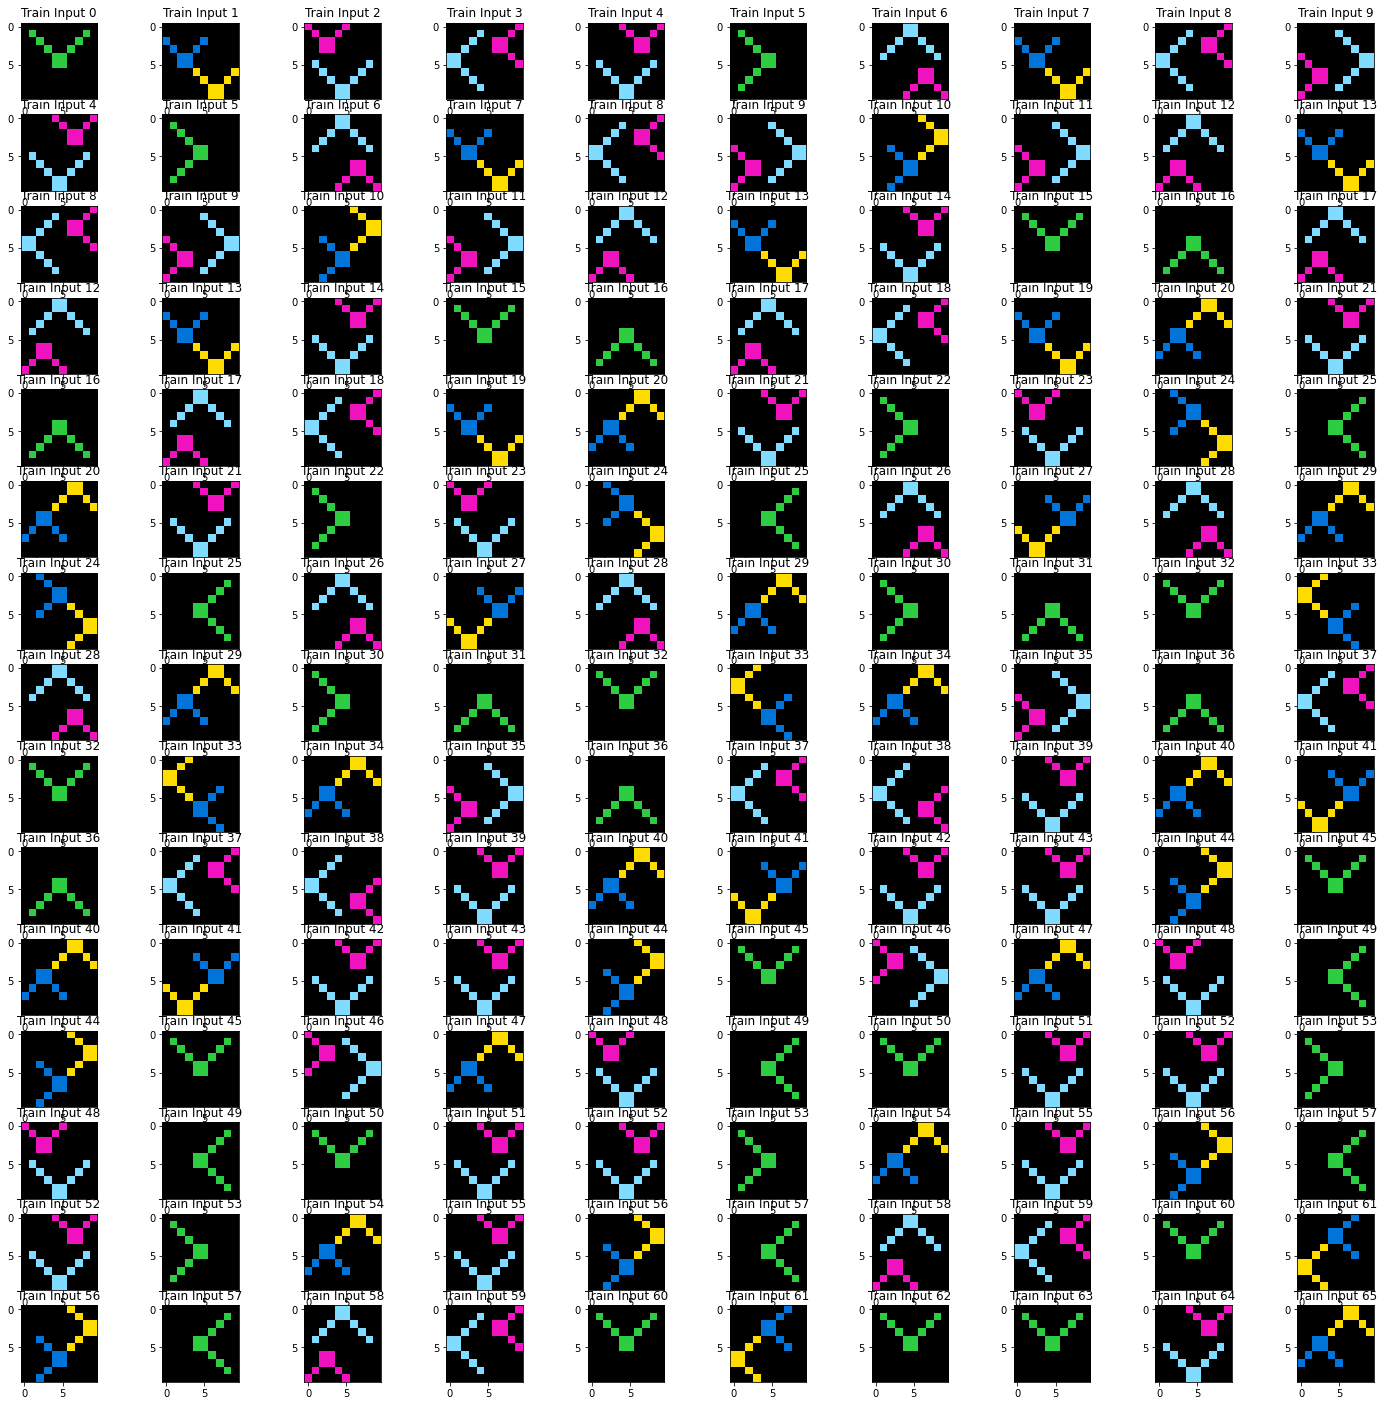

In [72]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(15, 10, figsize=(25,25))
for i in range(15):
    for j in range(10):
        idx = i+j+3*i
        
        ax[i,j].imshow((Xs_train_aug[40][idx])*10, cmap=cmap, norm=norm)
        ax[i,j].set_title(f'Train Input {idx}')